# RKD Artists

## Number of female artists

The cell below firstly defined a number of functions that can be used to run SPAQRL queries and to analyse the results in Python. 

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
from IPython.core.display import display, HTML
import pandas as pd
import re
from IPython.core.display import display, HTML

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

endpoint = 'https://api.data.netwerkdigitaalerfgoed.nl/datasets/rkd/rkdartists/services/rkdartists-jena/sparql'
sparql = SPARQLWrapper(endpoint)

def run_query(sparql_query):
    sparql.setQuery(sparql_query)
    sparql.setReturnFormat(JSON)
    data = sparql.query().convert()
    df = pd.json_normalize(data['results']['bindings'])  
    return df

def print_results(df):
    for i,row in df.iterrows():
        for column in df.columns:
            if re.search('value$' , column):
                print( f'{column} => {row[column]}' )
        print('-------')

In [2]:
query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rkdo: <http://data.rkd.nl/def#>
PREFIX schema: <http://schema.org/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?id

WHERE {
?id a schema:Person .
}
"""

df = run_query(query)

The RKD database contains descriptions of more than 220,000 people. 

In [4]:
print( df.shape[0] )

220793


The RKD Sparql endpoint offers access to an impressive amount of information about artists. The query below requests information about the painter Piet Mondriaan. 

In [5]:
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint = 'https://api.data.netwerkdigitaalerfgoed.nl/datasets/rkd/rkdartists/services/rkdartists-jena/sparql'
query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rkdo: <http://data.rkd.nl/def#>
PREFIX schema: <http://schema.org/>
prefix wd: <http://www.wikidata.org/entity/>
prefix wdt: <http://www.wikidata.org/prop/direct/>

SELECT ?name ?gender ?nationality ?id ?add ?alternate ?pob ?birth_date 
?pod ?death_date ?edu_name  ?title ?image ?event ?event_desc ?event_location ?event_lat  ?event_long  ?event_date 

WHERE {

?artist schema:identifier '56854' .
?artist schema:name ?name .
OPTIONAL { ?artist schema:gender ?gender . } .
OPTIONAL { ?artist schema:nationality ?nationality . } .
OPTIONAL { ?artist schema:identifier ?id . } .
OPTIONAL { ?artist schema:additionalType ?add . } .
OPTIONAL { ?artist schema:alternateName ?alternate . } .

?artist rkdo:Birth ?birth .
OPTIONAL { ?birth schema:location ?pob . } .
OPTIONAL { ?birth schema:startDate ?birth_date  . } .

  
?artist rkdo:Death ?death .
OPTIONAL { ?death schema:location ?pod . } .
OPTIONAL { ?death schema:startDate ?death_date . } .
  
?artist rkdo:Education ?edu .
OPTIONAL { ?edu schema:name ?edu_name. } .
  
?artist schema:event ?event.
OPTIONAL { ?event schema:description ?event_desc . } .
OPTIONAL { ?event schema:location ?event_location . } .
OPTIONAL { ?event schema:latitude ?event_lat . } .
OPTIONAL { ?event schema:longitude ?event_long . } .
OPTIONAL { ?event schema:startDate ?event_date .} .

service <https://query.wikidata.org/bigdata/namespace/wdq/sparql> {

?work wdt:P31 wd:Q3305213;
    wdt:P170 wd:Q151803;
    wdt:P18 ?image;
    wdt:P1476 ?title;
}
  
FILTER (lang(?name) = 'nl')
}

"""

df = run_query(query)


In [6]:
import pandas as pd
import numpy as np 


first = df.iloc[0]
print( f"Name: {first['name.value']}" )
print( f"https://rkd.nl/nl/explore/artists/{first['id.value']}" )

print( f"\nGender: {first['gender.value'][first['gender.value'].rindex('/')+1:]}" )
print( f"Date of birth: {first['birth_date.value']}" )
print( f"Date of death: {first['death_date.value']}" )

print('\nAlternative names:')
names = df['alternate.value']
for name in names.drop_duplicates().values:
    print(name)
    
print('\nEducation:')
edu = df['edu_name.value']
for education in edu.drop_duplicates().values:
    print(education)
    

print('\nEvents:')
df['event_duplicated'] = df.duplicated(subset='event_desc.value', keep='first')

events = df[ df['event_duplicated'] == False ]
events = events.sort_values('event_date.value')
for i,row in events.iterrows():
    print( f"{row['event_date.value']}\n{row['event_desc.value']} ")
    

print('\nWorks:')
df['works_duplicated'] = df.duplicated(subset='title.value', keep='first')

works = df[ df['works_duplicated'] == False ]
for i,row in works.iterrows():
    print( f"{row['title.value']}\n")
    display(HTML(f'<img src="{row["image.value"]}" style="width: 200px; " />'))


    

Name: Mondriaan, Piet
https://rkd.nl/nl/explore/artists/56854

Gender: Male
Date of birth: 1872-03-07
Date of death: 1944-02-01

Alternative names:
Mondrian, Piet
Mondriaan, Pieter Cornelis

Education:
Rijksakademie van beeldende kunsten (Amsterdam)

Events:
1908
nan 
1909
also West-Kapelle 
1911
visits Paris for ten days in mid-June (Bois 1994) 
1912-03
lives at avenue du Maine 33 (Bois 1994) 
1912-05
lives at rue du Départ 26 (Bois 1994) 
1919-06-22
due to finding his old studio at 26 rue du Départ occupied by Tour Dones, moves into the vacant studio Kickert had occupied briefly in 1912 in the same building (Bois 1994) 
1919-11-01
moves to a new studio at rue de Coulmiers 5 (Bois 1994) 
1921-10-22
returns to rue du Départ, where he occupies the larger studio of the Stieltjes (Bois 1994) 
1936-03-20
moves into new quarters in the studio building at boulevard Raspail 278 (Bois 1994) 

Works:
Composition C



Composition with red, blue, black, yellow and gray



Tableau I



Trafalgar Square



Windmill with Summerhouse II



Composition with color planes 2



Grazende kalfjes



Zomernacht



Oostzijdse molen in maanlicht



Composition



Tableau No. IV; Lozenge Composition with Red, Gray, Blue, Yellow, and Black



Farm near Duivendrecht



Composition (No. 1) Gray-Red



Composition with Blue, Yellow, and Red



Schilderij No. 1



Composition - blanc, rouge et jaune: A



Composition with Blue, Red, Yellow, and Black



Composition with Blue and Red



Red Gladioli



Irises



Geschoten haas



Composition no.XIII (authentic)



Composition en couleurs



Three chrysanthemum blossoms



Portrait of Egbert Kuipers (1828-1892)



Portret van Egbert Kuipers (1828-1892)



Portrait of Egbert Kuipers (1828-1892) and Jantje Wiegersma (1828-...)



Portret van Egbert Kuipers (1828-1892) en Jantje Wiegersma (1828-...)



Female head in profile



The four seasons



Girl looking to her left



Farm interior with woman peeling potatoes



Windmill in sunlight near a stream



Haystack and farm sheds in a field



Haystack with willow trees



Small house along a canal



Three Italian poplars and buildings



Goats grazing near buildings



House in the countryside



Farm sheds and haystacks in the dunes



Farm building near Laren



Farmstead in Het Gooi with three buildings



Small farm buildings in Het Gooi



Farm building in Het Gooi, viewed from a field



Farm buildings in Het Gooi, veiled by trees



Farmyard in Het Gooi flanked by saplings



Shipworks



Scheepstimmerwerf (authentiek)



Lange Bleekerssloot with tower of the West Church



Lange Bleekerssloot with barge



Lange Bleekerssloot: view toward the Kostverlorenvaart



Houses and paltrok mill on the Voorweg



Footbridge in the Schinkelbuurt



Factory district near the Boerenwetering



U



Unloading a sand barge



Moored barge with horses



Irrigation ditch with mature willow



Polder landscape with irrigation ditch



Polder landscape with irrigation ditch and fence



Polder landscape with irrigation ditch and five cows



Fox Trot A



By the Sea



Composition (no. III) blanc-jaune



New York City 2 (unfinished)



Church at Zoutelande, three-quarter view



Beach with five piers at Domburg



Rear gable of an Achterhoek farm building



Willow suspended over the water before farm building and church tower



Composition II ; Composition 2 avec rouge et bleu



Composition en rouge, bleu et blanc II



Field with Young Trees in the Foreground



Victory Boogie Woogie



Compositie in lijn



Gemälde no.I



Molen aan 't Gein



Broadway Boogie Woogie



grande composizione A con nero, rosso, grigio, giallo e blu



De rode boom



De grijze boom



Tableau I (Schilderij I)



Composition with Yellow, Blue and Red



Composition with yellow, black, blue, red, and gray



Open landscape, train along the horizon



Oostzijdse Mill along the River Gein by Moonlight



Oostzijdse molen aan het Gein bij maanlicht



Composition: No. III, with Red, Yellow, and Blue



Compositie: no. III, met rood, geel en blauw



Apple Tree, Pointillist Version



Composition with Large Blue Plane, Red, Black, Yellow, and Gray



Windmill



Farm Near Duivendrecht, in the Evening



Composition no. XVI (authentic)



Vuurtoren bij Westkapelle



Evolutie



Stilleven met gemberpot 2



Molen; Molen bij zonlicht



Molen bij Domburg



Molen; De rode molen



Bomen aan het Gein: opkomende maan



Devotie



Bosch; Bos bij Oele



Kerk te Domburg



Zeeuwsche kerktoren



Metamorfose



Compositie met groot rood vlak, geel, zwart, grijs en blauw



Tableau no. 2



New York City



Composition with grid 1



Composition in oval with color planes 1



View from the dunes with beach and piers, Domburg



Post mill at Heeswijk, rear view



Composition - blanc et rouge: B



Composition with grid 4



Composition no. 10



Composition with color planes and gray lines 1



Oostzijdse mill with panoramic sunset and brightly reflected colors



Lozenge Composition with Yellow, Black, Blue, Red, and Gray



Windmolen



Stammer Mill with Streaked Sky



Portret van Pieter Cornelis Mondriaan (1872-1944)



Portrait of Pieter Cornelis Mondriaan (1872-1944)



Zelfportret



Rastercompositie 9: dambordcompositie heldere kleuren



Composition with red, blue and yellow



Compositie 10 in zwart wit



Duin III



Brabant farm building and shed



Zomer, duin in Zeeland



Stilleven met gemberpot 1



Composition no. III



Compositie



Tableau 2



Composition no. I



Composition no. 1



Truncated view of the Broekzijder mill on the Gein, wings facing west



Gemälde no. II



Compositie no.5



Compositie met rood, blauw, zwart, geel en grijs



Boerderij



Kopie naar de Pietà van Villeneuve-Lès-Avignon door Enguerrand Quarton



Oostzijdse molen



Boerderij Landzicht



Duinen bij Domburg



Compositie met rood, zwart, geel, blauw en grijs



Zee na zonsondergang



Huisje bij zon



De rode wolk



Slootje bij boerderij Landzicht



Op het land



Avond aan het Gein



Portret van D.J. Hulshoff Pol



Portret van J.P.G. Hulshoff Pol



Avondlandschap



Boerderij met boerin aan de was



Knotwilgenbosje langs het Gein



Eenzame boom aan het Gein



Compositie no. 3 met kleurvakjes



Boerderij aan een sloot met bomen



Compositie met gele lijnen



Boomgaard met kippen



Groot landschap



Avondlandschap aan het Gein



Landschap met bomen aan het Gein



Molen achter hoge bomen



Gezicht op de Schinkelbuurt



Het Gein: Bomen aan het water



Duin IV



Compositie met rood, geel, zwart, blauw en grijs



Boerderij met bomen



Weidelandschap met koeien



Boerderij, Brabant



Dorpsgezicht



Avond



De Kostverlorenvaart



Twee chrysanten



Wilgen aan het Gein



Baggermolen



Weide met koeien



Bos



Bloeiende bomen



Landweg met huizen



Studie naar twee koeien



Mijmering



Roodbonte vaars in de weide



Twee figuren



Vrouwen met kind voor boerderij



Sloot met twee wilgen



Boerenhoeve aan een sloot



Bij de ossenstal



Schuur te Nistelrode



Het Gein: bomen aan het water



Boerderijen met op de voorgrond een hek



Huis aan het water met vrouw aan de was



Avondlandschap met koeien



De Koninklijke Waskaarsenfabriek



De Boerenwetering



Boerderij met wilgen aan het Gein



Bleekerij aan het Gein



Boerderij tussen eikenbomen



Wilgenbosje



Tableau No. 3: Composition in Oval



Tableau no. 3: compositie in ovaal



Stilleven met haringen



Still Life with Herrings



Painting No. II / Composition No. XV / Composition 4



Schilderij no. II / Compositie no. XV / Compositie 4



Composition with Yellow, Red, Black, Blue, and Gray



Compositie met geel, rood, zwart, blauw en grijs



kaka



Composition No.IV, with Red, Blue, and Yellow



Farm Setting, Four Tall Trees in the Foreground I



Boerderij met vier hoge bomen in de voorgrond I



Composition with Blue, Yellow, Red, Black, and Gray



Compositie met blauw, geel, rood, zwart en grijs



Lozenge Composition with Two Lines



Ruitvormige compositie met twee lijnen



Willow grove, trunks leaning left I



Still life with a plaster bust



Mannelijk naakt



Willow grove with prominent trunk at center



Sun, Church in Zeeland; Zoutelande Church Facade



Composition B (No.II) with Red



No. VI / Composition No.II



Composition no. II



The trees



Farmstead under oak trees II



Fox Trot B, with Black, Red, Blue, and Yellow



Post mill at Heeswijk, side view



Landscape with three reclining cows



Landschap bij Uden



Portrait of Cornelis Bergman (c. 1903-...)



Portret van Cornelis Bergman (c. 1903-...)



Stammer mill with summer house



Broekzijder mill in the evening



Oostzijdse mill viewed from downstream with streaked pinkish-blue sky



Oostzijdse mill from downstream with evenly streaked sky



Oostzijdse mill with streaked reddish sky



Oostzijdse mill with extended light blue, yellow and violet sky



Oostzijdse mill, vertical oil sketch with blue sky



Oostzijdse mill with cropped wings



Oostzijdse mill with panoramic sunset, mill at center



Oostzijdse mill with panoramic sunset, mill at right



Panoramic sunset with two windmills



Windmill near tall trees, other trees at right



Windmill near tall trees with woman at the wash stoop



Windmill with tall trees and moored barges



Landzicht farm under light blue sky



Haystacks III



Mand met appelen



Still Life with Sunflower



Composition with Red, Blue, Yellow, Black, and Gray



Het Zeeuws meisje



Ships in the moonlight



Schepen in het maanlicht



Church seen from the rear



Gezicht op de achterzijde van een kerk



Pitcher with onions



Kan met uijen (authentiek)



Thy word is the truth



Uw woord is de waarheid (authentiek)



Puppy



Farm interior with hearth in the Achterhoek



Boereninterieur met haard in de Achterhoek



Aardappelschillende vrouw



Woman peeling potatoes



Woman with spindle



Vrouw met spindel



Lane with sheaves of rye



Laan met roggeschoven



D



Schemering



Brook with sluice near Winterswijk



Beek met sluis bij Winterswijk



Warmth



Warmte (authentiek)



Stream bordered by wooded landscape



Boslandschap met beek



Achterhoek farmhouse with haystack



Boerderij met hooimijt in de Achterhoek



Portrait of Dorothy Gretchen Biersteker (1891-1978)



Portret van Dorothy Gretchen Biersteker (1891-1978)



Portrait of Queen Wilhelmina (1880-1962) as a princes



Princesje (authentiek)



Women doing the wash



Vrouwen aan de was



Field with church tower and haystack



Landschap met kerktoren en hooiberg



Irrigation ditch with wood gate at left



Polderlandschap met sloot en houten hek



Irrigation ditch, bridge and goat, sketch



Polderlandschap met brug en geit, schets



Waalseilandsgracht with bridge and moored tjalk barges



Waalseilandsgracht met brug en afgemeerde tjalken



Waalseilandgracht with bridge and flat barges



Waalseilandgracht met brug en platbodems



Farm buildings with trees and water ditch



Boerderijen met bomen en sloot



Scattered trees on sloping land



Glooiend landschap met bomen



Trees and cows along a stream



Trees and cows in a field



Wood near Driebergen



T



Three farm workers near a gateway



Spring idyll



Lente idylle (authentiek)



The Lappenbrink, view toward the Nieuwstraat, oil sketch



Near the Lappenbrink



Farm buildings in Winterswijk



Farmyard in the Achterhoek



Farm buildings with bridge



Farmyard with carriage barn in the Achterhoek



Winter landscape with three farm buildings



Fields with stacked sheaves of rye



Two girls in a wood



Study of apples



Appelstudie (authentiek)



Apples, coffee pot and large copper pan



Still life: apples, pot with flowers and metal pan



Stilleven (authentiek)



Oranges and decorated plate



Sinaasappelen (authentiek)



White phloxes



Witte floxen



Yellow chrysanthemums in a ginger pot



Three chrysanthemum blossoms in a round pot



Polder landscape with group of five cows



Two trees silhouetted behind a water course



Farm setting with foreground tree and irrigation ditch



Free impression of a polder landscape



Polder with moored boat near Amsterdam I



Polder with moored boat near Amsterdam II



Polder landscape, smoke rising in background



Fragment of an irrigation ditch



Irrigation ditch with pollarded willows



Beach scene



Rocky coast in England



House on the Gein, 1741



House on the Gein, 1741, reversed sketch



Façade of Maria's Hoeve farm building on the Gein



Gabled farmhouse façade in white



Gabled farmhouse façade with large gateposts



Two gabled house façades along a canal



Truncated view of a gabled house façade on a canal



Farmhouse with garden



Farm buildings near a canal with small boat



Truncated view of tjalk and house façade



Still life with mirror, containers, honesty and fruit



Portrait of Louise Charlotte Mathilde van den Bosch (1843-1907)



Portret van Louise Charlotte Mathilde van den Bosch (1843-1907)



Windmill with church towers in the distance



Vinkenbrug te Diemen



Curved irrigation ditch bordering farmyard with flowering trees



Fields overlooking Arnhem from the north



Roadway and farm building near Arnhem



Six young birch trees in a field



On the Ringdijk, Watergraafsmeer



Op de Ringdijk, Watergraafsmeer (authentiek)



Farm building with white side façade



Farmhouse façade with curb roof



Gabled farmhouse façade with tree, fence and gateposts in front



Gabled farmhouse with row of trees and blue sky



Buildings along the water with a wash stoop



Irrigation ditch with cows and sheltered farm complex



Farmyard with sheep



Barn and haystack behind row of willows



Farmyard sketch with pollarded willow at left



Farmyard sketch with two cows grazing



Willows bordering a watercourse, buildings left and right



Willows bordering an irrigation ditch near a haystack



The white bull calf



Oostzijdse mill viewed from dock at Landzicht farm



Oostzijdse mill, oil sketch in square format



Farmhouse along the water shielded by arch of trees II



Willow grove, trunks leaning left II



The home: Hannes van Nistelrode at his pot stove



De Herd (authentiek)



Brabant farm building with pump



White irises against a light blue background II



Haystacks I



Haystacks II



Row of eleven poplars in red, yellow, blue and green



Two trees with orange foliage against blue sky



Blue willow tree I



Blue willow tree II



Apple tree in blue with wavy lines I



Apple tree in blue with wavy lines II



Oil sketch for blue apple tree series



Apple tree in blue



House façade with green trimmed shutters



Beach with one pier at Domburg



Pointillist dune study, crest at left



Pointillist study with dunes and sea



New York City 3 (unfinished)



Zwartbonte vaars in de weide



Bloeiende appelboom



Apple Tree in Bloom



Boerderij met wasgoed aan de lijn



Chrysanthemum



Tableau 3



Composition with grid 5: lozenge composition with colors



Rastercompositie 8: dambordcompositie donkere kleuren



Composition B



Composition en blanc et noir II



Composition no.II



Composition no.VI



Composition No. IV (Compositie No. IV) / Compositie 6



Compositie bomen 2



Composition de lignes et couleur: III (Compositie met lijnen en met kleur: III)



Compositie in kleur B



Composition with grid 6



Composition no. 9



Composition en blanc, rouge et bleu



Composition with grid 7



Duin I



Boerderij met hooiberg



Tree



Compositie met grijze lijnen



New York City 1 (unfinished)



New York



Kindje



Spring Sun (Lentezon): Castle Ruin: Brederode



Tableau III: Composition in Oval



Tableau III: compositie in ovaal



:0



Arbre



The Tree A



The Winkel Mill, Pointillist Version



Rose in a glass



Willow Grove: Impression of Light and Shadow



Tableau no. III



Tableau no. 1



Beach with three or four piers at Domburg



Compositie in kleur A



Farm near Duivendrecht, in the evening



Composition no.XI (authentic)



Composition no.XI (authentiek)



Landzicht farm



Wilgen met zon (studie olieverf)



Koeien in de wei



Landschap bij maanlicht



Ven bij Saasveld



Korenschoven in het veld



Boerderij bij Duivendrecht



Boerderij in de avond



Isar Harlemia



Veld met bomen bij avond



Het Singel, Amsterdam



Onderschildering voor land en lucht



Boerderij te Blaricum



Werf te Durgerdam



Bomen langs het Gein



Avondstemming aan de Amstel (De Omval)



Vrouw bij boerderij



Onderschildering voor avondlandschap



Veld met bomengroep bij avond II



Schaapskooi in de avond



Veld met bomengroep bij avond I



Boerderij Geinrust in de nevel



Stervende zonnebloem I



Stervende zonnebloem II



Zeegezicht



Duin II



Aäronskelk; Blauwe bloem



Aäronskelken



Zeeuwsche boer



Kerk te Oostkapelle



Duinlandschap



Paysage (Landschap)



Landschap met bomen



Portret van een dame



Het grote naakt



Compositie bomen 1



Tableau No. 4 (Schilderij No. 4) / Composition No.VIII / Compositie 3



Compositie in ovaal met kleurvlakken 2



Molen bij avond



Polder landscape with irrigation ditch and two cows



Brabant barn interior



Stier



Gezicht op een rij huizen met een landweg



Sloot met brug



Knotwilgen



Boom



Twee aronskelken



Geinrust farm with three small trees at left



Geinrust farm with truncated tall trees and saplings



Geinrust farm surrounded by dense foliage



Geinrust farm with isolated tree at left



Isolated tree on the Gein with yellow-orange sky



Isolated tree on the Gein with gray sky



Isolated tree on the Gein: detail study



Willow grove near the water with chickens



Bend in the Gein with poplars II



Bend in the Gein with poplars, three isolated



Bend in the Gein with poplars



Bend in the Gein with row of eleven poplars I



Bend in the Gein with row of eleven poplars III



Farmstead with long row of trees on the Gein



Farmstead on the Gein screened by tall trees with streaked sky



Farmstead on the Gein screened by tall trees: ultramarine sky with yellow ray of sunset



Landscape with appel tree at left



Landscape with apple tree at left: winter landscape



Meandering river, windmill in the distance



Sailboat moored in a river



Landscape with pink cloud



Farm buildings in white and red near a green field



Farm setting, four tall trees in the foreground II



Summer night: preliminary study in oil



Moored tjalk and other barges



Moored tjalk in purple



Moored tjalk



On Ouderkerkerdijk near the Omval in the evening II



Mooring docks near the Omval



Dredge III



Farmstead under oak trees III



Farmstead façade with leafless oak



Farmhouse façade with well boom at left



Farm building and well



Sheepfold with flock of sheep



Farm building with well in daylight



Fen near Saasveld



Two haystacks in a field I



Evening



Avond (authentiek)



Evening sky with luminous cloud streaks



Field with row of trees at left



Field with gate and trees at right



Silhouette of a spreading tree



Magnolia



Anemones in a vase



Red chryanthemum on blue background



Foxtail lily



Flower arrangement with rhodondendrons and irises



White irises against a light blue background I



Eucalyptus (authentic)



The sea



Flowering trees



Bloeiende bomen (authentiek)



Eucalyptus



Eucalyptus (authentiek)



Composition no. X (authentic)



Tableau no.I



Composition with color planes: façade



Color study with pink, blue, yellow and white



Composition with color planes 4



Composition with color planes and gray lines 2



Composition with color planes and gray lines 3



Composition no. 15



Composition I



Composition II



Composition III



Unfinished composition



Tableau no. I



Composition with yellow, blue, black, red, and gray



Composition with large yellow plane



Composition with large red plane



Composition with large red plane, black, blue, yellow and gray



Tableau no. II



Composition with large red plane, blue, gray, black and yellow



Tableau II



Composition with blue, yellow, red and gray



Composition with Blue, Black, Yellow, and Red



Tableau no. V



Composition with blue, red, yellow, and black



Composition with yellow, blue, and blue-white



Composition with large red plane, bluish gray, yellow, black, and blue



Composition with blue, yellow, black, and red



Compostion with red, black, yellow, blue, and gray



Composition 1922



Tableau



Tableau no. IV



Tableau no. VIII



Tableau no. XI



Composition with red, black, blue, and yellow



Rythme de lignes droites (et couleur?)



Composition no. 7



Composition no. 11



On a river bank



Aan de oever



Portrait of Martha Frieda de Fries (1893-...)



Portret van Martha Frieda de Fries (1893-...)



Portrait of a woman in a yellow hat



Meisje met geel hoedje



Landweg met boerderij



Country road and farm



Landweg



Country road



Portrait of a little boy



Klein Jantje



Ceiling decoration of putti and birds



Plafondschildering met putti en vogels



Haystack behind trees



Hooimijt achter een rij bomen



Farmstead with willows on the water



Boerderij met wilgen aan het water



Farm along the river Gein



Boerderij langs 't Gein



Oostzijdse mill



A farmhouse behind a fence



Willow grove with boats near the river Gein



Cows beside the water (copy after Stortenbeker)



Koeien bij het water (kopie naar Stortenbeker)



The query below selects all artists from the 19th century.

In [7]:
query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rkdo: <http://data.rkd.nl/def#>
PREFIX schema: <http://schema.org/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?id ?name ?gender ?date_birth ?date_death

WHERE {
?id a schema:Person .
?id schema:name ?name .
?id rkdo:Birth ?birth .
?id schema:gender ?gender .
OPTIONAL {
    ?birth schema:startDate ?date_birth . } .
?id rkdo:Death ?death .
OPTIONAL {
    ?death schema:startDate ?date_death . } .
    
FILTER ( ?date_birth >= "1800-01-01"^^xsd:date && ?date_birth < "1900-01-01"^^xsd:date)

}
ORDER BY ?name
"""

df = run_query(query)

The query returns the names of 31623 artists. 

In [8]:
df = df.drop_duplicates(subset=['id.value'])
print( df.shape[0] )

31623


In [9]:
query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rkdo: <http://data.rkd.nl/def#>
PREFIX schema: <http://schema.org/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?id ?name ?gender ?date_birth ?date_death

WHERE {
?id a schema:Person .
?id schema:name ?name .
?id schema:gender ?gender .
?id rkdo:Birth ?birth .
OPTIONAL {
    ?birth schema:startDate ?date_birth . } .
?id rkdo:Death ?death .
OPTIONAL {
    ?death schema:startDate ?date_death . } .
    
FILTER ( ?date_birth >= "1700-01-01"^^xsd:date && ?date_birth < "1800-01-01"^^xsd:date)

}
ORDER BY ?name
"""

df = run_query(query)

The RKD database 4857 artists who were born in the 18th century.

In [10]:
df = df.drop_duplicates(subset=['id.value'])
print( df.shape[0] )

4857


In [11]:
df.shape[0]

4857

In [12]:
import pandas as pd
import numpy as np 

female = df[ df['gender.value'] == 'http://schema.org/Female']
male = df[ df['gender.value'] == 'http://schema.org/Male']

print( f'Out of the {df.shape[0]} artists born in the 18th century, {female.shape[0]} are female and {male.shape[0]} are male.' )




Out of the 4857 artists born in the 18th century, 280 are female and 4577 are male.


The names of the female artists from the 18th century are as follows:

In [13]:
max = 20

female.reset_index(drop=True)

for index,row in female.iterrows():
    print(row['name.value'])
    print(row['id.value'] , end='\n\n')
    if index == max:
        break

Anna Pavlovna of Russia
https://data.rkd.nl/artists/60896

Catherine the Great
https://data.rkd.nl/artists/440104

Charlotte of Mecklenburg-Strelitz (Queen of Great-Britain and Hanover)
https://data.rkd.nl/artists/487057

Czartoryska (née Fleming), Izabela Dorota (Princess)
https://data.rkd.nl/artists/457810

Maria Theresa of Austria
https://data.rkd.nl/artists/52596

Wilhelmina of Pruissia (Queen of the Netherlands)
https://data.rkd.nl/artists/368338

Abesch, Anna Barbara
https://data.rkd.nl/artists/204

Aerssen, Josina Anna Petronella van
https://data.rkd.nl/artists/359913

Alberda van Ekenstein, Anna Josina Petronella
https://data.rkd.nl/artists/471535

Alderwerelt, Sara Maria Helena van
https://data.rkd.nl/artists/427702

Alphen, Petronella Cornelia van
https://data.rkd.nl/artists/353886

Ancelot, Marguerite Virginie
https://data.rkd.nl/artists/1602

Anhalt-Dessau, Henriette Amalie von
https://data.rkd.nl/artists/440391

Anna Amalia van Brunswijk (hertogin van Saksen-Weimar-Eisenac

We can see that, during the 18th century, the number of female artists increases quite quickly. 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


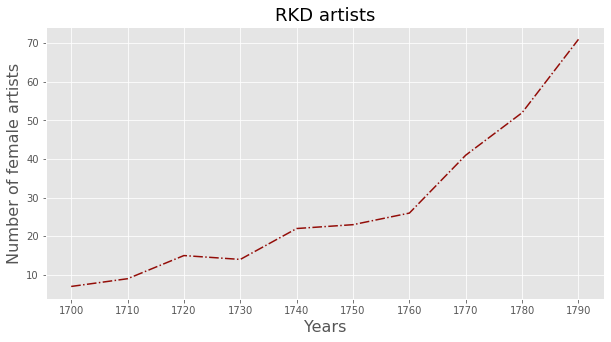

In [14]:
## add column 'decade'
female['year'] = pd.DatetimeIndex(female['date_birth.value']).year
female['decade'] = female['year'] / 10
female['decade'] = np.floor(female['decade']).astype(int) * 10


counts = female.groupby('decade').size()
counts = counts.to_frame()

%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig = plt.figure( figsize = ( 10, 5))
ax = plt.axes()

ax.plot( counts.index , counts.values , color = '#930d08' , linestyle = 'dashdot')

ax.set_xlabel('Years', size = 16)
ax.set_ylabel('Number of female artists', size = 16 )


ax.set_title( 'RKD artists', size = 18)
plt.xticks(counts.index)

plt.show()

In [15]:
query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rkdo: <http://data.rkd.nl/def#>
PREFIX schema: <http://schema.org/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?id ?name ?gender ?date_birth ?date_death

WHERE {
?id a schema:Person .
?id schema:name ?name .
?id schema:gender schema:Female .
?id rkdo:Birth ?birth .
OPTIONAL {
    ?birth schema:startDate ?date_birth . } .
?id rkdo:Death ?death .
OPTIONAL {
    ?death schema:startDate ?date_death . } .
    
FILTER ( ?date_birth >= "1800-01-01"^^xsd:date && ?date_birth < "1900-01-01"^^xsd:date)

}
ORDER BY ?name
"""

df = run_query(query)

The increase continues during the 19th century. 

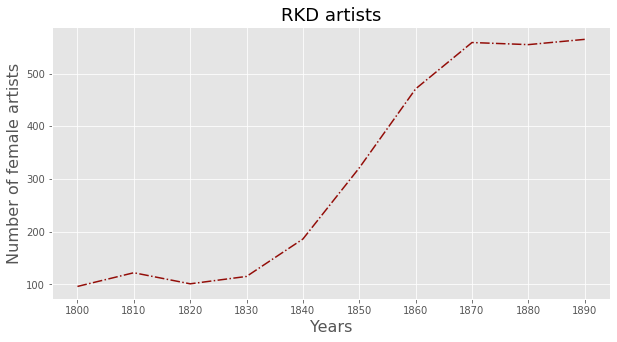

In [16]:
## add column 'decade'
df['year'] = pd.DatetimeIndex(df['date_birth.value']).year
df['decade'] = df['year'] / 10
df['decade'] = np.floor(df['decade']).astype(int) * 10
counts = df.groupby('decade').size()
counts = counts.to_frame()

%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig = plt.figure( figsize = ( 10, 5))
ax = plt.axes()

ax.plot( counts.index , counts.values , color = '#930d08' , linestyle = 'dashdot')

ax.set_xlabel('Years', size = 16)
ax.set_ylabel('Number of female artists', size = 16 )


ax.set_title( 'RKD artists', size = 18)
plt.xticks(counts.index)

plt.show()